In [1]:
# Necessary imports
import os
import time
import timeit
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
%matplotlib inline

# Modelling packages
from sklearn import ensemble
from sklearn.feature_selection import chi2, f_classif, SelectKBest 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import adjusted_rand_score, classification_report, confusion_matrix, silhouette_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import normalize

# Plotly packages
import cufflinks as cf
import ipywidgets as widgets
import plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly import tools
from scipy import special
py.offline.init_notebook_mode(connected=True)

C:\Users\mhuh22\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Import the data
listings = pd.read_csv('listings.csv')
neighborhoods = pd.read_csv('neighbourhoods.csv')
neighborhood_map = pd.read_json('neighbourhoods.geojson')

# Remove the 'id' column from the dataframe
listings.drop(['id', 'host_id'], axis=1, inplace=True)

In [3]:
# Preview the data for listings
listings.head()

,name,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,"Casa Madrona - Urban Oasis, 1 block from the P...",Megan,Central Area,Madrona,47.610819,-122.290816,Entire home/apt,296,4,20,2018-09-18,0.16,3,345
1,Sunrise in Seattle Master Suite,Jess & Joey,Other neighborhoods,Roosevelt,47.687801,-122.313427,Private room,82,2,63,2018-10-06,0.96,5,365
2,"Cozy Studio, min. to downtown -WiFi",Maddy,Delridge,South Delridge,47.523980,-122.359891,Entire home/apt,48,3,461,2018-11-02,4.37,1,24
3,"Fab, private seattle urban cottage!",Joyce,Other neighborhoods,Wallingford,47.654109,-122.337605,Entire home/apt,90,2,134,2018-10-21,1.18,3,287
4,Glorious sun room w/ memory foambed,Angielena,Other neighborhoods,Georgetown,47.550620,-122.320135,Private room,65,2,130,2018-09-09,1.29,5,336


In [4]:
# View the size of the dataframe
listings.shape

(8740, 14)

In [5]:
# Check for any missing values
listings.isna().sum()

name                                 0
host_name                            0
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       1048
reviews_per_month                 1049
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [6]:
# View descriptive statistics
listings.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,8740.000000,8740.000000,8740.000000,8740.000000,8740.000000,7691.000000,8740.000000,8740.000000
mean,47.626403,-122.333693,152.228375,3.691419,42.772769,2.462089,22.570252,138.483295
std,0.045696,0.031548,141.676868,13.235492,63.760075,2.427051,62.737811,130.909168
min,47.496037,-122.419637,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,47.606366,-122.354144,80.000000,1.000000,3.000000,0.565000,1.000000,14.000000
50%,47.621423,-122.332098,119.000000,2.000000,17.000000,1.690000,1.000000,89.000000
75%,47.661255,-122.312031,189.000000,2.000000,55.000000,3.820000,5.000000,263.000000
max,47.736128,-122.234026,5400.000000,400.000000,717.000000,46.410000,311.000000,365.000000


C:\Users\mhuh22\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



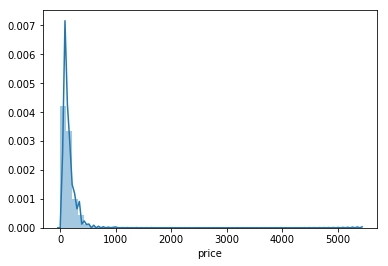

In [7]:
sns.distplot(listings['price'])

In [8]:
listings.sort_values(by = 'price', ascending=False).head(10)

,name,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
7845,Light &Airy home--convenient Seattle location,Deanna,Central Area,Harrison/Denny-Blaine,47.621206,-122.293840,Entire home/apt,5400,7,0,NaN,NaN,1,143
8107,We are true 12's!,Chris,Queen Anne,West Queen Anne,47.630456,-122.367444,Entire home/apt,4000,1,0,NaN,NaN,1,0
1041,Neat & Roomy Photography Studio,Steve,Central Area,Minor,47.602292,-122.308681,Entire home/apt,3999,29,58,2016-09-21,1.29,5,0
5405,Spacious Family-Friendly Tri-Plex with Views i...,Kimberly,Queen Anne,West Queen Anne,47.630824,-122.368964,Entire home/apt,1650,2,3,2018-08-07,0.22,5,222
3908,Seattle Executive Home for Large Gatherings,Andrew,Seward Park,Seward Park,47.547348,-122.266204,Entire home/apt,1395,7,2,2018-08-19,0.10,1,358
6963,Summer Apart (girls only),Happy,University District,University District,47.663574,-122.315006,Private room,1250,7,0,NaN,NaN,1,365
3892,Beautiful French Style Home with Panoramic Views.,Amy,Queen Anne,Lower Queen Anne,47.629652,-122.360114,Entire home/apt,1200,4,2,2017-08-06,0.10,1,8
6982,LARGE HOUSE ON LAKE WASHINGTON WITH HOT TUB!!!!,Jason,Central Area,Leschi,47.591348,-122.287627,Entire home/apt,1129,30,9,2018-08-09,1.57,12,365
4485,Family luxury-steps to Columbia City & light r...,Joel And Amanda,Rainier Valley,Columbia City,47.558111,-122.289506,Entire home/apt,1079,2,20,2018-10-07,1.15,1,362
904,Private Townhome 2 bedroom 1.5 bath,Natalie,Rainier Valley,Mount Baker,47.564861,-122.285446,Entire home/apt,1000,2,23,2018-06-29,0.48,1,0


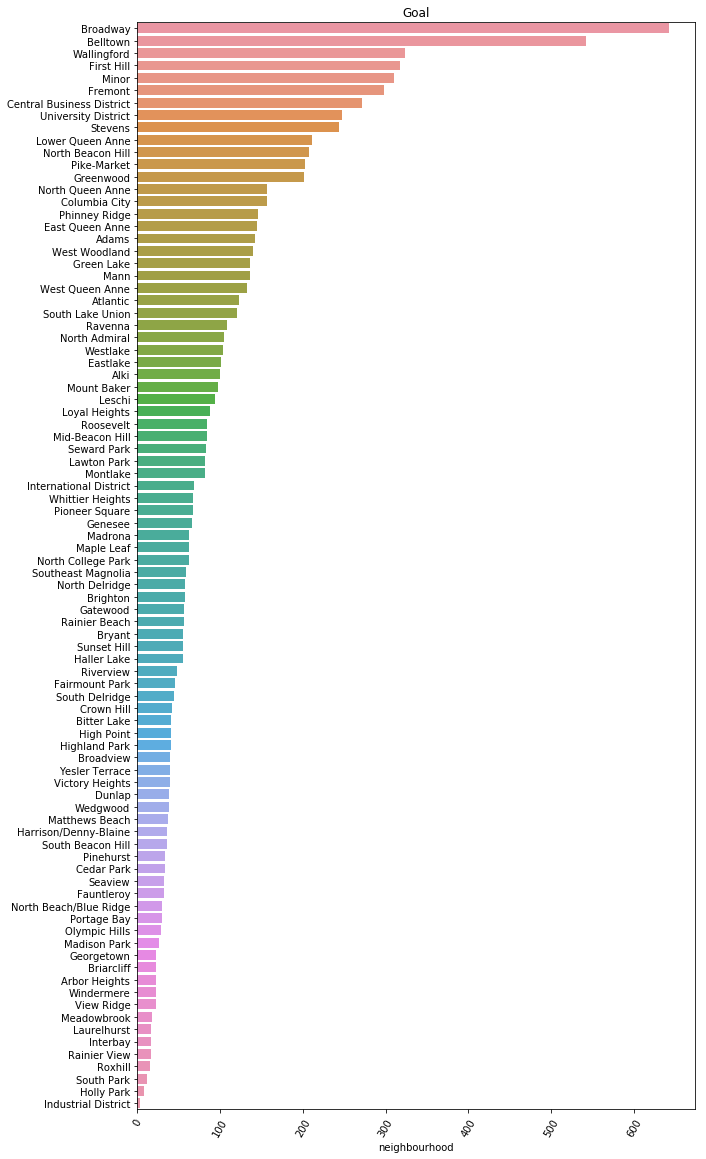

In [24]:
plt.rcParams['figure.figsize'] = [10,20]

plt.title('Goal')
plt.xticks(rotation=60)
sns.barplot(x = listings['neighbourhood'].value_counts(),
            y = listings['neighbourhood'].value_counts().index)

In [10]:
neighborhood_map2 = pd.concat(neighborhood_map, listings['neighbourhood'].value_counts())

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [ ]:
neighborhood_map.head()

In [25]:
mapbox_access_token = 'pk.eyJ1IjoibWh1aDIyIiwiYSI6IkpGdEhkXzgifQ.Af4NVoaKw7lvlqVyak8Ydw'

data = go.Data([
    go.Scattermapbox(
        mode='markers',
        locations = listings['neighbourhood_group'],
        text = listings['neighbourhood_group'],
    )
])

layout = go.Layout(
    title = 'Airbnb Units in Seattle',
    height=600,
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        layers=[
            dict(
                sourcetype = 'geojson',
                source = 'neighbourhoods.geojson',
                type = 'fill',
                color = 'rgba(40,0,113,0.8)'
            )
        ],
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=47.6062,
            lon=-122.3321
        ),
        pitch=0,
        zoom=9.5,
        style='light'
    ),
)

fig = dict(data=data, layout=layout)
py.offline.iplot(fig, filename='county-level-choropleths-python')

ValueError: Invalid property specified for object of type plotly.graph_objs.Scattermapbox: 'locations'

    Valid properties:
        connectgaps
            Determines whether or not gaps (i.e. {nan} or missing
            values) in the provided data arrays are connected.
        customdata
            Assigns extra data each datum. This may be useful when
            listening to hover, click and selection events. Note
            that, "scatter" traces also appends customdata items in
            the markers DOM elements
        customdatasrc
            Sets the source reference on plot.ly for  customdata .
        fill
            Sets the area to fill with a solid color. Use with
            `fillcolor` if not "none". "toself" connects the
            endpoints of the trace (or each segment of the trace if
            it has gaps) into a closed shape.
        fillcolor
            Sets the fill color. Defaults to a half-transparent
            variant of the line color, marker color, or marker line
            color, whichever is available.
        hoverinfo
            Determines which trace information appear on hover. If
            `none` or `skip` are set, no information is displayed
            upon hovering. But, if `none` is set, click and hover
            events are still fired.
        hoverinfosrc
            Sets the source reference on plot.ly for  hoverinfo .
        hoverlabel
            plotly.graph_objs.scattermapbox.Hoverlabel instance or
            dict with compatible properties
        hovertext
            Sets hover text elements associated with each (lon,lat)
            pair If a single string, the same string appears over
            all the data points. If an array of string, the items
            are mapped in order to the this trace's (lon,lat)
            coordinates. To be seen, trace `hoverinfo` must contain
            a "text" flag.
        hovertextsrc
            Sets the source reference on plot.ly for  hovertext .
        ids
            Assigns id labels to each datum. These ids for object
            constancy of data points during animation. Should be an
            array of strings, not numbers or any other type.
        idssrc
            Sets the source reference on plot.ly for  ids .
        lat
            Sets the latitude coordinates (in degrees North).
        latsrc
            Sets the source reference on plot.ly for  lat .
        legendgroup
            Sets the legend group for this trace. Traces part of
            the same legend group hide/show at the same time when
            toggling legend items.
        line
            plotly.graph_objs.scattermapbox.Line instance or dict
            with compatible properties
        lon
            Sets the longitude coordinates (in degrees East).
        lonsrc
            Sets the source reference on plot.ly for  lon .
        marker
            plotly.graph_objs.scattermapbox.Marker instance or dict
            with compatible properties
        mode
            Determines the drawing mode for this scatter trace. If
            the provided `mode` includes "text" then the `text`
            elements appear at the coordinates. Otherwise, the
            `text` elements appear on hover.
        name
            Sets the trace name. The trace name appear as the
            legend item and on hover.
        opacity
            Sets the opacity of the trace.
        selected
            plotly.graph_objs.scattermapbox.Selected instance or
            dict with compatible properties
        selectedpoints
            Array containing integer indices of selected points.
            Has an effect only for traces that support selections.
            Note that an empty array means an empty selection where
            the `unselected` are turned on for all points, whereas,
            any other non-array values means no selection all where
            the `selected` and `unselected` styles have no effect.
        showlegend
            Determines whether or not an item corresponding to this
            trace is shown in the legend.
        stream
            plotly.graph_objs.scattermapbox.Stream instance or dict
            with compatible properties
        subplot
            Sets a reference between this trace's data coordinates
            and a mapbox subplot. If "mapbox" (the default value),
            the data refer to `layout.mapbox`. If "mapbox2", the
            data refer to `layout.mapbox2`, and so on.
        text
            Sets text elements associated with each (lon,lat) pair
            If a single string, the same string appears over all
            the data points. If an array of string, the items are
            mapped in order to the this trace's (lon,lat)
            coordinates. If trace `hoverinfo` contains a "text"
            flag and "hovertext" is not set, these elements will be
            seen in the hover labels.
        textfont
            Sets the icon text font. Has an effect only when `type`
            is set to "symbol".
        textposition
            Sets the positions of the `text` elements with respects
            to the (x,y) coordinates.
        textsrc
            Sets the source reference on plot.ly for  text .
        uid

        unselected
            plotly.graph_objs.scattermapbox.Unselected instance or
            dict with compatible properties
        visible
            Determines whether or not this trace is visible. If
            "legendonly", the trace is not drawn, but can appear as
            a legend item (provided that the legend itself is
            visible).
        

In [ ]:
df.head()

In [ ]:
# df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_us_cities.csv')
# df.head()

# df['text'] = df['name'] + '<br>Population ' + (df['pop']/1e6).astype(str)+' million'
# limits = [(0,2),(3,10),(11,20),(21,50),(50,3000)]
# colors = ["rgb(0,116,217)","rgb(255,65,54)","rgb(133,20,75)","rgb(255,133,27)","lightgrey"]
# cities = []
# scale = 5000

# for i in range(len(limits)):
#     lim = limits[i]
#     df_sub = df[lim[0]:lim[1]]
#     city = go.Scattergeo(
#         locationmode = 'USA-states',
#         lon = df_sub['lon'],
#         lat = df_sub['lat'],
#         text = df_sub['text'],
#         marker = go.scattergeo.Marker(
#             size = df_sub['pop']/scale,
#             color = colors[i],
#             line = go.scattergeo.marker.Line(
#                 width=0.5, color='rgb(40,40,40)'
#             ),
#             sizemode = 'area'
#         ),
#         name = '{0} - {1}'.format(lim[0],lim[1]) )
#     cities.append(city)

# layout = go.Layout(
#         title = '2014 US city populations<br>(Click legend to toggle traces)',
#         showlegend = True,
#         geo = go.layout.Geo(
#             scope = 'usa',
#             projection = go.layout.geo.Projection(
#                 type='albers usa'
#             ),
#             showland = True,
#             landcolor = 'rgb(217, 217, 217)',
#             subunitwidth=1,
#             countrywidth=1,
#             subunitcolor="rgb(255, 255, 255)",
#             countrycolor="rgb(255, 255, 255)"
#         )
#     )

# fig = go.Figure(data=cities, layout=layout)
# py.offline.iplot(fig, filename='d3-bubble-map-populations')

In [ ]:
get_ipython().run_cell_magic('html', '', '<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js"></script>')